In [15]:
#Monte Carlo simulation to find optimum portfolio 
import pandas as pd
import numpy as np
import quandl
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-01-01')

In [3]:
#reading data from yahoo finance
aapl = web.DataReader('AAPL','yahoo',start,end)
cisco = web.DataReader('CSCO','yahoo',start,end)
ibm = web.DataReader('IBM','yahoo',start,end)
amzn = web.DataReader('AMZN','yahoo',start,end)

In [4]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.629209
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.697079
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.838044
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.972249
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.951672


In [5]:
#using adj close price
stocks = pd.concat([aapl['Adj Close'],cisco['Adj Close'],ibm['Adj Close'],amzn['Adj Close']],axis=1)
stocks.columns = ['aapl','cisco','ibm','amzn']

In [6]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,12.629209,14.035937,133.390823,179.029999
2012-01-04,12.697079,14.307162,132.846649,177.509995
2012-01-05,12.838044,14.254426,132.216583,177.610001
2012-01-06,12.972249,14.201690,130.698685,182.610001
2012-01-09,12.951672,14.292099,130.018463,178.559998


In [7]:
#log of daily returns is more accurate than regular arithmetic returns and can be proven statistically
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010399,-0.003707,-0.011547,0.027763
2012-01-09,-0.001588,0.006346,-0.005218,-0.022428


In [33]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [8]:
num_ports = 15000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio = return/volatility
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [10]:
sharpe_arr.max()

1.0299060745650686

In [11]:
sharpe_arr.argmax()

12871

In [12]:
all_weights[12871,:]

array([0.24876593, 0.20321749, 0.00062451, 0.54739207])

In [13]:
max_sr_ret = ret_arr[12871]
max_sr_vol = vol_arr[12871]

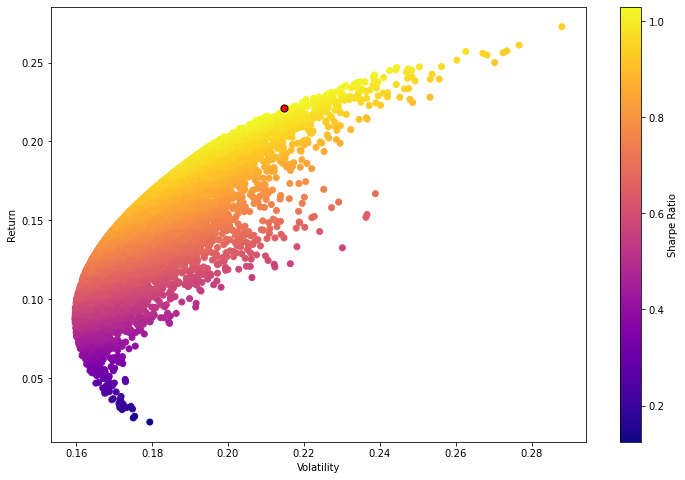

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [17]:
#Monte Carlo simulation done
#Now we will use a mathematical optimization strategy using minimize function from scipy to find ideal weights
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [18]:
from scipy.optimize import minimize

In [19]:
#Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, 
#we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1



In [20]:
# Constraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [21]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [22]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [23]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [24]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [25]:
opt_results

     fun: -1.0304880351958305
     jac: array([ 5.65648079e-05,  4.05013561e-05,  3.39574814e-01, -4.40031290e-05])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66270607e-01, 2.03920312e-01, 8.19453554e-17, 5.29809082e-01])

In [26]:
#returns optimal weights
opt_results.x

array([2.66270607e-01, 2.03920312e-01, 8.19453554e-17, 5.29809082e-01])

In [27]:
get_ret_vol_sr(opt_results.x)

array([0.21890444, 0.21242793, 1.03048804])

In [28]:
#Creating the efficient frontier:
#The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of 
#risk or the lowest risk for a given level of expected return. 
#Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for 
#the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have
#a higher level of risk for the defined rate of return.

In [29]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100)

In [30]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]

In [31]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

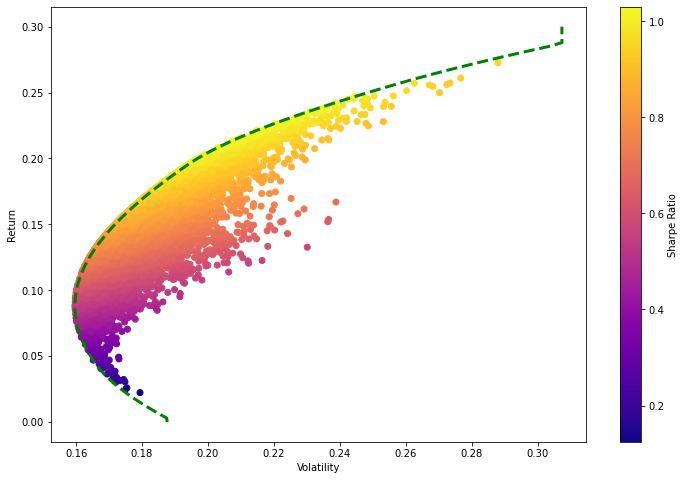

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)